# Initialize

In [41]:
import os
from typing import Dict, Any, Tuple
import numpy as np
# import scipy

import pandas as pd
import polars as pl

import skfuzzy as fuzz
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns


path_proj_root = '/Users/curtismcginity/stanford/research/proj/MoTrPAC/dev/'
path_data = os.path.join(path_proj_root, 'data')
path_data_r6m = os.path.join(path_data, 'rat-6m')
path_contrast_time_txt = os.path.join(path_data_r6m, 'rat-acute-06_t68-liver_epigen-atac-seq_da_timewise-deseq2-phase-frip-t2f_v2.0.txt')
path_indv_tsv = p=os.path.join(path_data_r6m, 'motrpac_pass1ac-06_epigen-atac-seq_t68-liver_stanford_limma_norm.tsv')

# paths to read in the pre-stored parquet files
ptxt = os.path.join(path_data_r6m, 'rat-acute-06_t68-liver_epigen-atac-seq_da_timewise-deseq2-phase-frip-t2f_v2.0.parquet')
pindv = os.path.join(path_data_r6m, 'motrpac_pass1ac-06_epigen-atac-seq_t68-liver_stanford_limma_norm.parquet')

# read in parquet files, filter for sex=male, then pass to pandas
dfplmale = pl.read_parquet(ptxt).filter(pl.col("sex") == "male")
dfmale = dfplmale.to_pandas()

def standardize_data_types(df):
    """
    Standardize data types of the dataframe according to specified requirements.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to standardize
        
    Returns:
    --------
    pandas.DataFrame
        The dataframe with standardized data types
    """
    # Convert text columns to string type
    text_columns = ['assay', 'feature_ID', 'tissue', 'contrast', 'timepoint', 'sex']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    # Convert float columns
    float_columns = ['logFC', 'lfcSE', 'p_value']
    for col in float_columns:
        if col in df.columns:
            df[col] = df[col].astype(float)
    
    # Handle adj_p_value column - convert 'NA' to 1.0
    if 'adj_p_value' in df.columns:
        # Replace 'NA' with 1.0
        df['adj_p_value'] = df['adj_p_value'].replace('NA', 1.0)
        # Convert to float
        df['adj_p_value'] = df['adj_p_value'].astype(float)
    
    return df


def classification_entropy(membership_matrix: np.ndarray) -> float:
    """Calculate entropy of fuzzy membership matrix: -1/n * sum_i sum_j (u_ij * log(u_ij))"""
    epsilon = np.finfo(float).eps
    u = np.clip(membership_matrix, epsilon, 1.0)
    n = membership_matrix.shape[1]
    return -1.0 / n * np.sum(u * np.log(u))


def xie_beni_index(data: np.ndarray, centers: np.ndarray, 
                  membership_matrix: np.ndarray, m: float) -> float:
    """Calculate Xie-Beni index: ratio of within-cluster compactness to between-cluster separation"""
    n = data.shape[0]  # Number of data points
    c = centers.shape[0]  # Number of clusters
    
    # Calculate compactness (numerator)
    u_power_m = membership_matrix ** m
    
    # Calculate squared distances between data points and centers
    squared_distances = np.zeros_like(membership_matrix)
    for j in range(c):
        squared_distances[j, :] = np.sum((data - centers[j, :]) ** 2, axis=1)
    
    compactness = np.sum(u_power_m * squared_distances)
    
    # Calculate separation (minimum distance between centers)
    if c > 1:
        # Explicitly calculate pairwise distances without using the inf trick
        min_dist_sq = float('inf')
        for i in range(c):
            for j in range(c):
                if i != j:  # Don't compare a center to itself
                    dist_sq = np.sum((centers[i] - centers[j]) ** 2)
                    min_dist_sq = min(min_dist_sq, dist_sq)
        
        # Guard against potential division by zero
        if min_dist_sq > 0:
            return compactness / (n * min_dist_sq)
        else:
            return float('inf')  # Centers are identical
    else:
        return float('inf')  # Only one cluster


def preprocess_data_for_clustering(df: pd.DataFrame) -> Tuple[np.ndarray, list, list]:
    """Transform dataframe into format for clustering: each feature_ID becomes a row with 7 timepoint values"""
    # Get unique timepoints and sort them
    timepoints = sorted(df['timepoint'].unique())
    
    # Create a pivot table: rows=feature_ID, columns=timepoint, values=logFC
    pivot_df = df.pivot_table(
        index='feature_ID', 
        columns='timepoint', 
        values='logFC',
        aggfunc='first'
    )
    
    pivot_df = pivot_df[timepoints]
    feature_ids = pivot_df.index.tolist()
    data = pivot_df.values
    
    return data, feature_ids, timepoints


def cmeans_clustering(
    df: pd.DataFrame,
    n_clusters: int = 2,
    fuzziness: float = 2.0,
    error: float = 0.001,
    max_iter: int = 100,
    random_seed: int = None
) -> Dict[str, Any]:
    """
    Cluster feature_IDs based on their logFC patterns across timepoints.
    Each feature_ID becomes one sample with 7 dimensions (timepoints).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe containing feature_ID, timepoint, and logFC columns
    n_clusters : int, default=2
        Number of clusters to form
    fuzziness : float, default=2.0
        Fuzziness parameter m where m > 1
    error : float, default=0.001
        Stopping criterion for convergence
    max_iter : int, default=100
        Maximum number of iterations
    random_seed : int, default=None
        Random seed for initialization. If None, a random value will be generated.
        
    Returns:
    --------
    Dict containing clustering results and parameters
    """
    # Preprocess data: each row is a feature_ID, each column a timepoint
    data, feature_ids, timepoints = preprocess_data_for_clustering(df)
    # Transpose data for skfuzzy (expects shape: features, samples)
    data_t = data.T
    
    # Handle random seed
    if random_seed is None:
        random_seed = np.random.randint(0, 10000)
    print(f"Using random seed: {random_seed}")
    # Set the random seed for numpy
    np.random.seed(random_seed)
    
    # Perform fuzzy c-means clustering
    cntr, u, _, d, jm, p, fpc = fuzz.cluster.cmeans(
        data=data_t,
        c=n_clusters,
        m=fuzziness,
        error=error,
        maxiter=max_iter,
        init=None
    )
    
    # Determine hard cluster assignments based on maximum membership
    cluster_assignments = np.argmax(u, axis=0)
    
    # Calculate metrics
    ce = classification_entropy(u)
    xbi = xie_beni_index(data, cntr, u, fuzziness)
    
    return {
        'centers': cntr,
        'membership': u,
        'cluster_assignments': cluster_assignments,
        'classification_entropy': ce,
        'xie_beni_index': xbi,
        'feature_ids': feature_ids,
        'timepoints': timepoints,
        'fpc': fpc,
        'random_seed': random_seed
    }

def plot_cluster_centroids(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    show_features: bool = True,
    feature_alpha: float = 0.15,
    palette: str = "viridis"
):
    """
    Plot cluster centroids as line plots with optional feature patterns.
    
    Parameters:
    -----------
    clustering_result : Dict
        Output from cmeans_clustering function
    df : pd.DataFrame
        Original dataframe with feature_ID, timepoint, and logFC
    show_features : bool, default=True
        Whether to show individual feature patterns within clusters
    feature_alpha : float, default=0.2
        Transparency for feature lines
    palette : str, default="viridis"
        Color palette to use for clusters
    """
    # Set seaborn style for professional scientific plots
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Extract key components from clustering result
    centers = clustering_result['centers']
    timepoints = clustering_result['timepoints']
    feature_ids = clustering_result['feature_ids']
    cluster_assignments = clustering_result['cluster_assignments']
    n_clusters = centers.shape[0]
    
    # Create color palette for clusters
    colors = sns.color_palette(palette, n_clusters)
    
    # Get assay and tissue name for title
    assay_name = df['assay'].iloc[0] if 'assay' in df.columns else ''
    tissue_name = df['tissue'].iloc[0] if 'tissue' in df.columns else ''
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Calculate y-axis range
    all_logfc = df['logFC'].values
    y_min, y_max = all_logfc.min(), all_logfc.max()
    y_range = y_max - y_min
    y_limits = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]
    
    # First plot individual feature patterns if requested
    if show_features:
        feature_to_cluster = {fid: c for fid, c in zip(feature_ids, cluster_assignments)}
        
        for feature_id, group in df.groupby('feature_ID'):
            if feature_id in feature_to_cluster:
                cluster = feature_to_cluster[feature_id]
                group_sorted = group.sort_values('timepoint')
                plt.plot(
                    group_sorted['timepoint'], 
                    group_sorted['logFC'], 
                    color=colors[cluster], 
                    alpha=feature_alpha,
                    linewidth=0.8
                )
    
    # Plot cluster centroids (thick lines)
    for i in range(n_clusters):
        plt.plot(
            timepoints, 
            centers[i], 
            color=colors[i], 
            linewidth=3, 
            label=f'Cluster {i+1}'
        )
    
    # Set x-ticks to timepoints with rotation
    plt.xticks(range(len(timepoints)), timepoints, rotation=45)
    
    # Set y-axis limits
    plt.ylim(y_limits)
    
    # Add labels and legend
    plt.xlabel('Timepoint')
    plt.ylabel('Log Fold Change')
    plt.title(f'{assay_name} {tissue_name} Male Cluster Centroids (n={n_clusters})')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_only_centroids(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    palette: str = "viridis"
):
    """
    Plot only the cluster centroids as line plots.
    
    Parameters:
    -----------
    clustering_result : Dict
        Output from cmeans_clustering function
    df : pd.DataFrame
        Original dataframe with feature_ID, timepoint, and logFC
    palette : str, default="viridis"
        Color palette to use for clusters
    """
    # Set seaborn style for professional scientific plots
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Extract key components from clustering result
    centers = clustering_result['centers']
    timepoints = clustering_result['timepoints']
    n_clusters = centers.shape[0]
    
    # Create color palette for clusters
    colors = sns.color_palette(palette, n_clusters)
    
    # Get assay and tissue name for title
    assay_name = df['assay'].iloc[0] if 'assay' in df.columns else ''
    tissue_name = df['tissue'].iloc[0] if 'tissue' in df.columns else ''
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Calculate y-axis range for centers only
    center_min = centers.min()
    center_max = centers.max()
    y_range = center_max - center_min
    y_limits = [center_min - 0.1 * y_range, center_max + 0.1 * y_range]
    
    # Plot cluster centroids (thick lines)
    for i in range(n_clusters):
        plt.plot(
            timepoints, 
            centers[i], 
            color=colors[i], 
            linewidth=3, 
            label=f'Cluster {i+1}'
        )
    
    # Set x-ticks to timepoints with rotation
    plt.xticks(range(len(timepoints)), timepoints, rotation=45)
    
    # Set y-axis limits
    plt.ylim(y_limits)
    
    # Add labels and legend
    plt.xlabel('Timepoint')
    plt.ylabel('Log Fold Change')
    plt.title(f'{assay_name} {tissue_name} Male Cluster Centroids (n={n_clusters})')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_individual_clusters(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    feature_alpha: float = 0.15,
    palette: str = "viridis"
):
    """
    Create individual plots for each cluster.
    
    Parameters:
    -----------
    clustering_result : Dict
        Output from cmeans_clustering function
    df : pd.DataFrame
        Original dataframe with feature_ID, timepoint, and logFC
    feature_alpha : float, default=0.3
        Transparency for feature lines
    palette : str, default="viridis"
        Color palette to use for clusters
    """
    # Set seaborn style for professional scientific plots
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Extract key components from clustering result
    centers = clustering_result['centers']
    timepoints = clustering_result['timepoints']
    feature_ids = clustering_result['feature_ids']
    cluster_assignments = clustering_result['cluster_assignments']
    n_clusters = centers.shape[0]
    
    # Create color palette for clusters
    colors = sns.color_palette(palette, n_clusters)
    
    # Get assay and tissue name for title
    assay_name = df['assay'].iloc[0] if 'assay' in df.columns else ''
    tissue_name = df['tissue'].iloc[0] if 'tissue' in df.columns else ''
    
    # Calculate y-axis range for consistency across plots
    all_logfc = df['logFC'].values
    y_min, y_max = all_logfc.min(), all_logfc.max()
    y_range = y_max - y_min
    y_limits = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]
    
    # Create mapping from feature_id to cluster
    feature_to_cluster = {fid: c for fid, c in zip(feature_ids, cluster_assignments)}
    
    # Create one plot for each cluster
    for cluster_idx in range(n_clusters):
        plt.figure(figsize=(10, 6))
        
        # First plot the individual features in this cluster
        for feature_id, group in df.groupby('feature_ID'):
            if feature_id in feature_to_cluster and feature_to_cluster[feature_id] == cluster_idx:
                group_sorted = group.sort_values('timepoint')
                plt.plot(
                    group_sorted['timepoint'], 
                    group_sorted['logFC'], 
                    color=colors[cluster_idx], 
                    alpha=feature_alpha,
                    linewidth=0.8
                )
        
        # Then plot the centroid
        plt.plot(
            timepoints, 
            centers[cluster_idx], 
            color=colors[cluster_idx], 
            linewidth=3, 
            label=f'Cluster {cluster_idx+1} Centroid'
        )
        
        # Count features in this cluster
        n_features = sum(1 for c in cluster_assignments if c == cluster_idx)
        
        # Set x-ticks to timepoints with rotation
        plt.xticks(range(len(timepoints)), timepoints, rotation=45)
        
        # Set y-axis limits
        plt.ylim(y_limits)
        
        # Add labels and legend
        plt.xlabel('Timepoint')
        plt.ylabel('Log Fold Change')
        plt.title(f'{assay_name} {tissue_name} Male - Cluster {cluster_idx+1} ({n_features} features)')
        plt.legend()
        
        # Adjust layout
        plt.tight_layout()
        plt.show()


def find_optimal_clusters(
    df: pd.DataFrame,
    cluster_range: range = range(3, 7),
    fuzziness: float = 2.0,
    random_seed: int = 9620
) -> Dict[str, Any]:
    """Find optimal number of clusters by evaluating metrics across cluster counts"""
    metrics = []
    all_results = {}
    
    for n in cluster_range:
        print(f"Clustering with {n} clusters...")
        result = cmeans_clustering(df, n_clusters=n, fuzziness=fuzziness, random_seed=random_seed)
        
        metrics.append({
            'n_clusters': n,
            'classification_entropy': result['classification_entropy'],
            'xie_beni_index': result['xie_beni_index'],
            'fpc': result['fpc']
        })
        
        all_results[n] = result
    
    metrics_df = pd.DataFrame(metrics)
    
    # Create metric plots for determining optimal clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(metrics_df['n_clusters'], metrics_df['xie_beni_index'], 'o-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Xie-Beni Index')
    ax1.set_title(f'Xie-Beni Index vs. Number of Clusters (fuzziness={fuzziness})')
    ax1.set_yscale('log')
    
    ax2.plot(metrics_df['n_clusters'], metrics_df['fpc'], 'o-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Fuzzy Partition Coefficient')
    ax2.set_title('FPC vs. Number of Clusters')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'metrics': metrics_df,
        'all_results': all_results
    }


dfmale = standardize_data_types(dfmale)
dfmale.info()

# identify and filter significant feature trajectories
# Count total number of feature_ID groups
total_groups = dfmale['feature_ID'].nunique()
print(f"Total number of feature_ID groups: {total_groups}")

sig_thresh = 0.05
# Add significance indicator to each row by group
dfmale['is_significant'] = (dfmale
    .groupby('feature_ID')['adj_p_value']
    .transform(lambda x: np.min(x) < sig_thresh)
    .astype(int)
)
# Add significant indicator to each row by timepoint
# dfmale['is_sig_timepoint'] = (dfmale['adj_p_value']
#     .transform(lambda x: np.min(x) < sig_thresh)
#     .astype(int)
# )

# Filter to keep only significant groups
dfmale_sig = dfmale[dfmale['is_significant'] == 1]

# Count significant groups and calculate percentage
sig_groups = dfmale_sig['feature_ID'].nunique()
sig_percentage = (sig_groups / total_groups) * 100

print(f"Number of significant feature_ID groups: {sig_groups}")
print(f"Percentage of significant groups: {sig_percentage:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8209208 entries, 0 to 8209207
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   assay        object 
 1   feature_ID   object 
 2   tissue       object 
 3   contrast     object 
 4   timepoint    object 
 5   sex          object 
 6   logFC        float64
 7   lfcSE        float64
 8   p_value      float64
 9   adj_p_value  float64
dtypes: float64(4), object(6)
memory usage: 626.3+ MB
Total number of feature_ID groups: 1172744
Number of significant feature_ID groups: 8249
Percentage of significant groups: 0.70%


# Run

Using random seed: 9620


/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_81468/3590732717.py:290: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


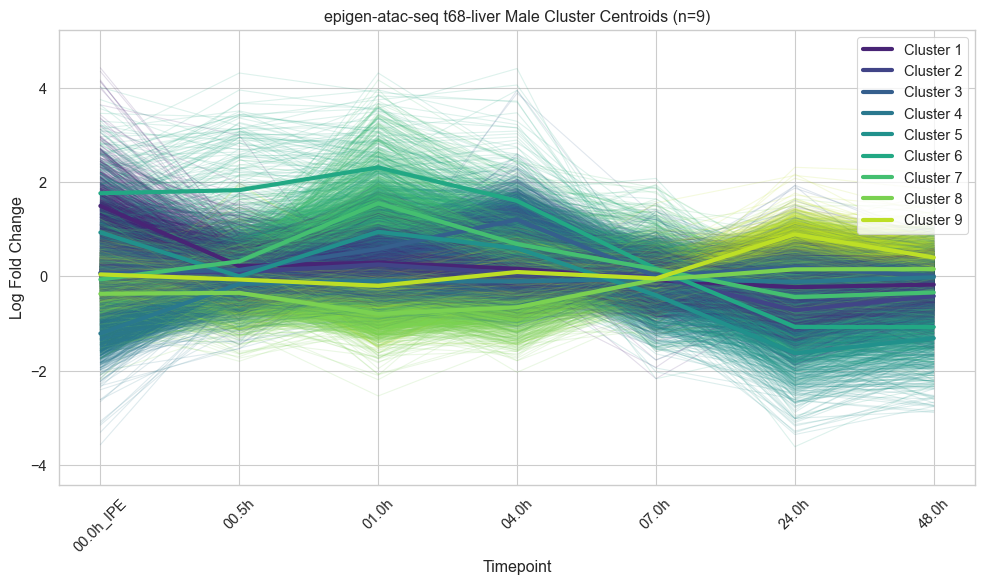

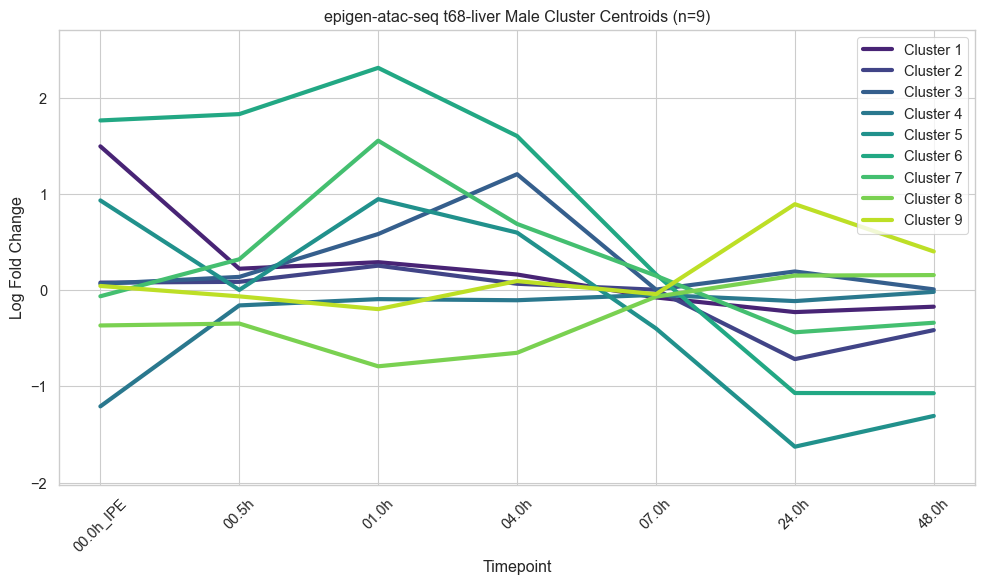

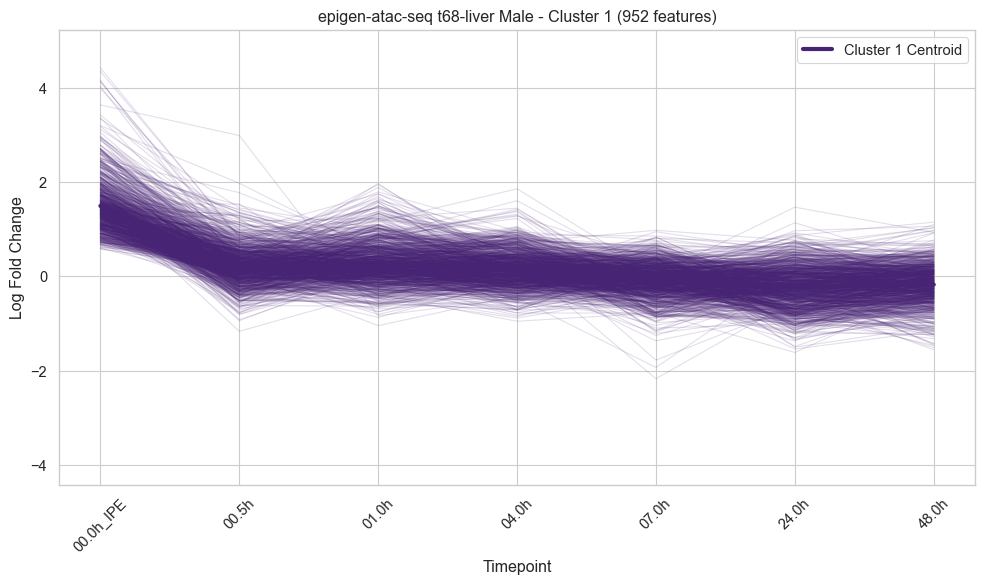

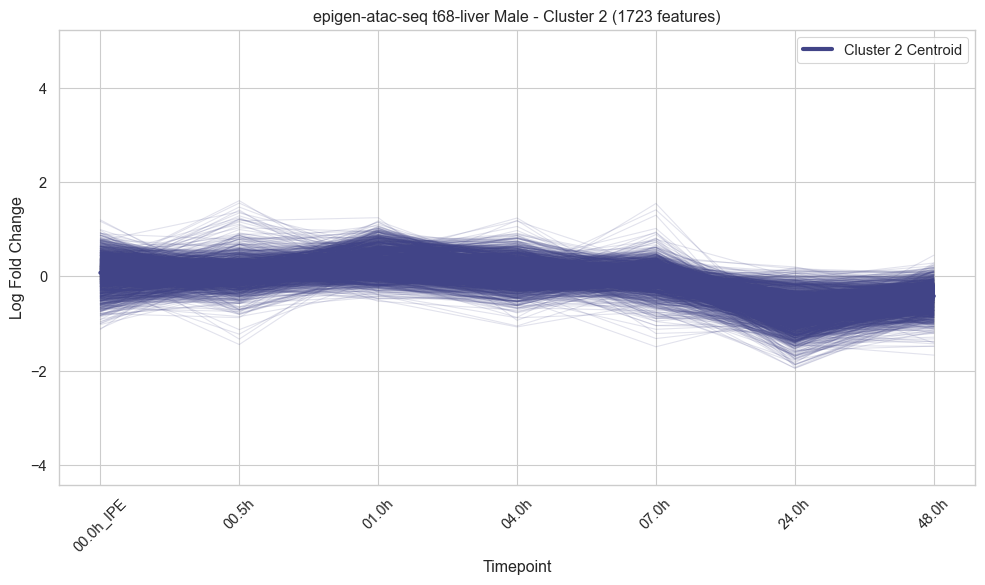

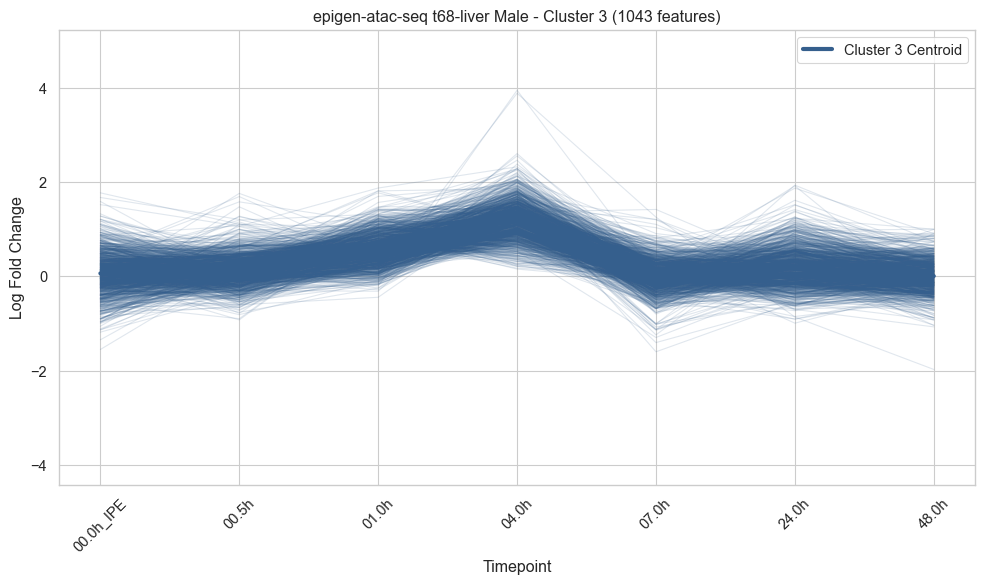

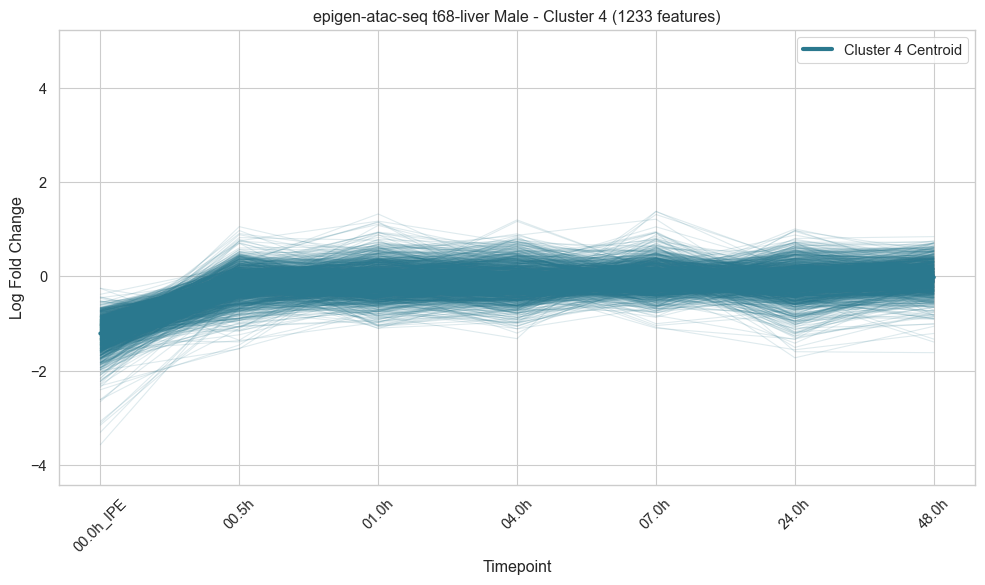

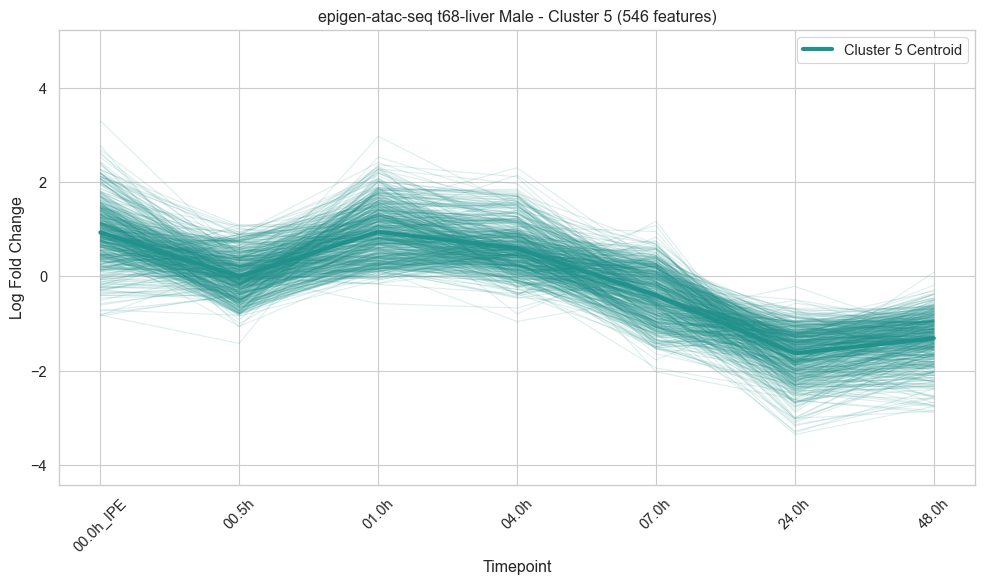

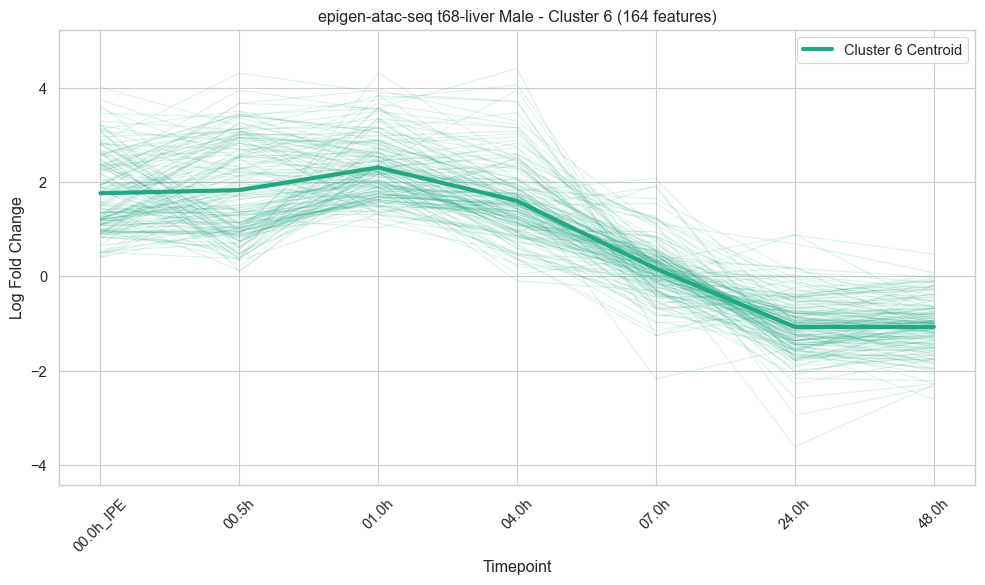

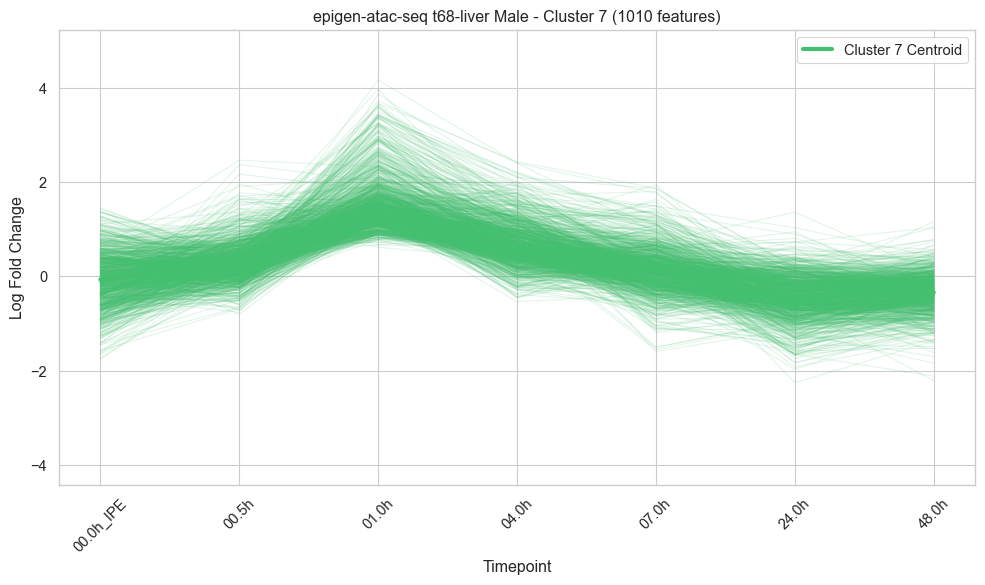

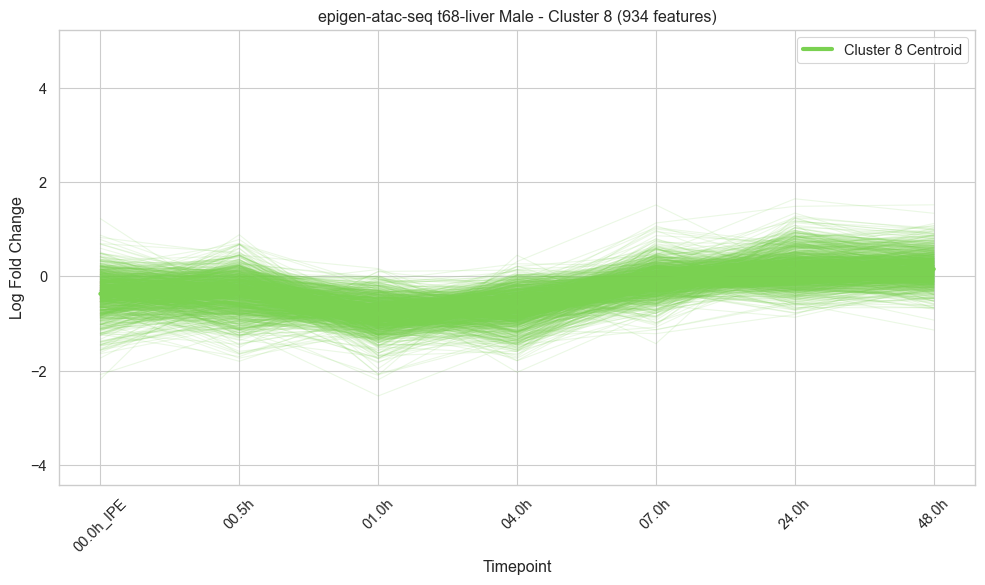

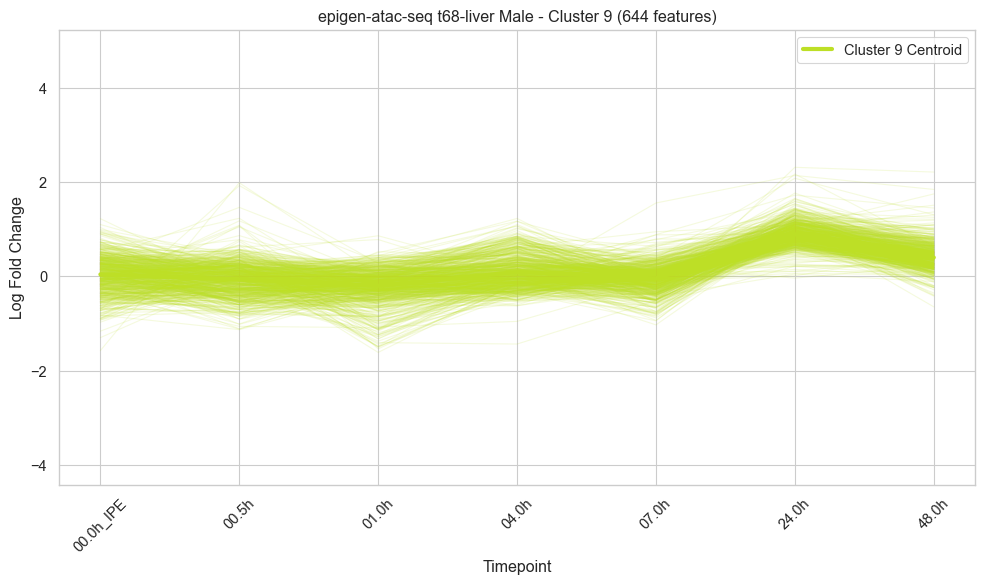

Clustering with 3 clusters...
Using random seed: 9620
Clustering with 4 clusters...
Using random seed: 9620
Clustering with 5 clusters...
Using random seed: 9620
Clustering with 6 clusters...
Using random seed: 9620
Clustering with 7 clusters...
Using random seed: 9620
Clustering with 8 clusters...
Using random seed: 9620
Clustering with 9 clusters...
Using random seed: 9620
Clustering with 10 clusters...
Using random seed: 9620
Clustering with 11 clusters...
Using random seed: 9620
Clustering with 12 clusters...
Using random seed: 9620
Clustering with 13 clusters...
Using random seed: 9620
Clustering with 14 clusters...
Using random seed: 9620
Clustering with 15 clusters...
Using random seed: 9620


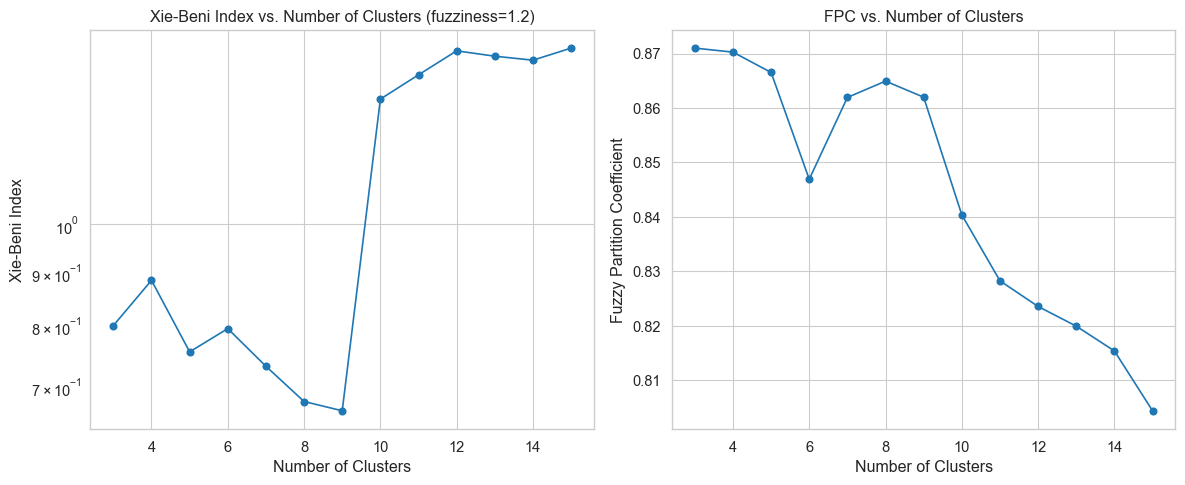

Optimal number of clusters based on Xie-Beni Index: 9


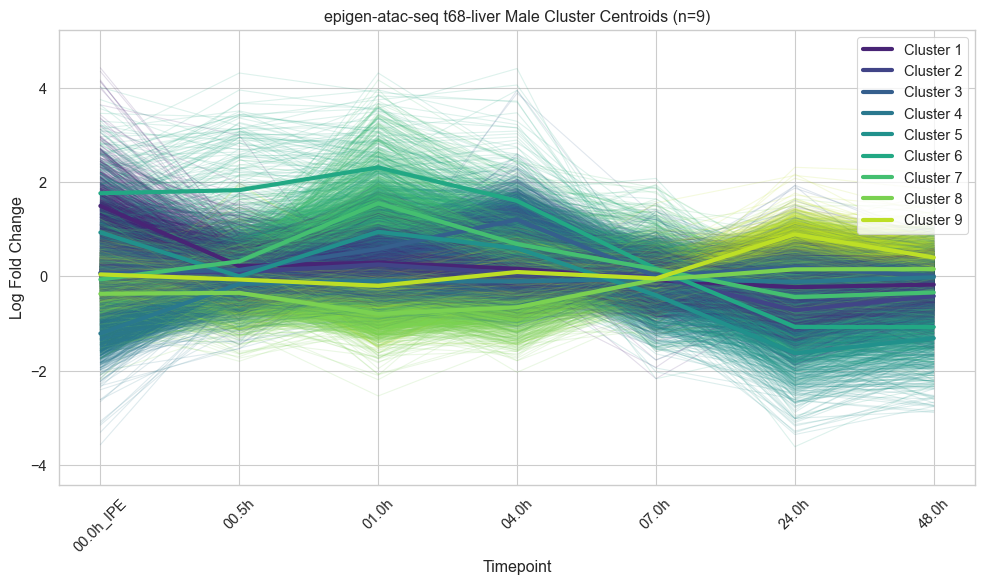

In [3]:
# clustering parameters
seed_male = 9620
fp = 1.2
mi = 1000


# Step 1: Run clustering with 3 clusters
results = cmeans_clustering(dfmale_sig, n_clusters=9, fuzziness=fp, max_iter=mi, random_seed=9620)

# Step 2: Plot all clusters together
plot_cluster_centroids(results, dfmale_sig)

plot_only_centroids(results, dfmale_sig)

# Step 3: Plot each cluster individually
plot_individual_clusters(results, dfmale_sig)
# plot_individual_clusters_sig(results, dfmale_sig)

# Step 4: Find optimal number of clusters
optimal_results = find_optimal_clusters(dfmale_sig, cluster_range=range(3, 16), fuzziness=fp)

# Step 5: Use the optimal number of clusters (based on XBI)
best_n = optimal_results['metrics']['n_clusters'].iloc[
    optimal_results['metrics']['xie_beni_index'].idxmin()
]
print(f"Optimal number of clusters based on Xie-Beni Index: {best_n}")

# Step 6: Get the optimal clustering results
optimal_clustering = optimal_results['all_results'][best_n]

# Step 7: Plot the optimal clustering
plot_cluster_centroids(optimal_clustering, dfmale_sig)

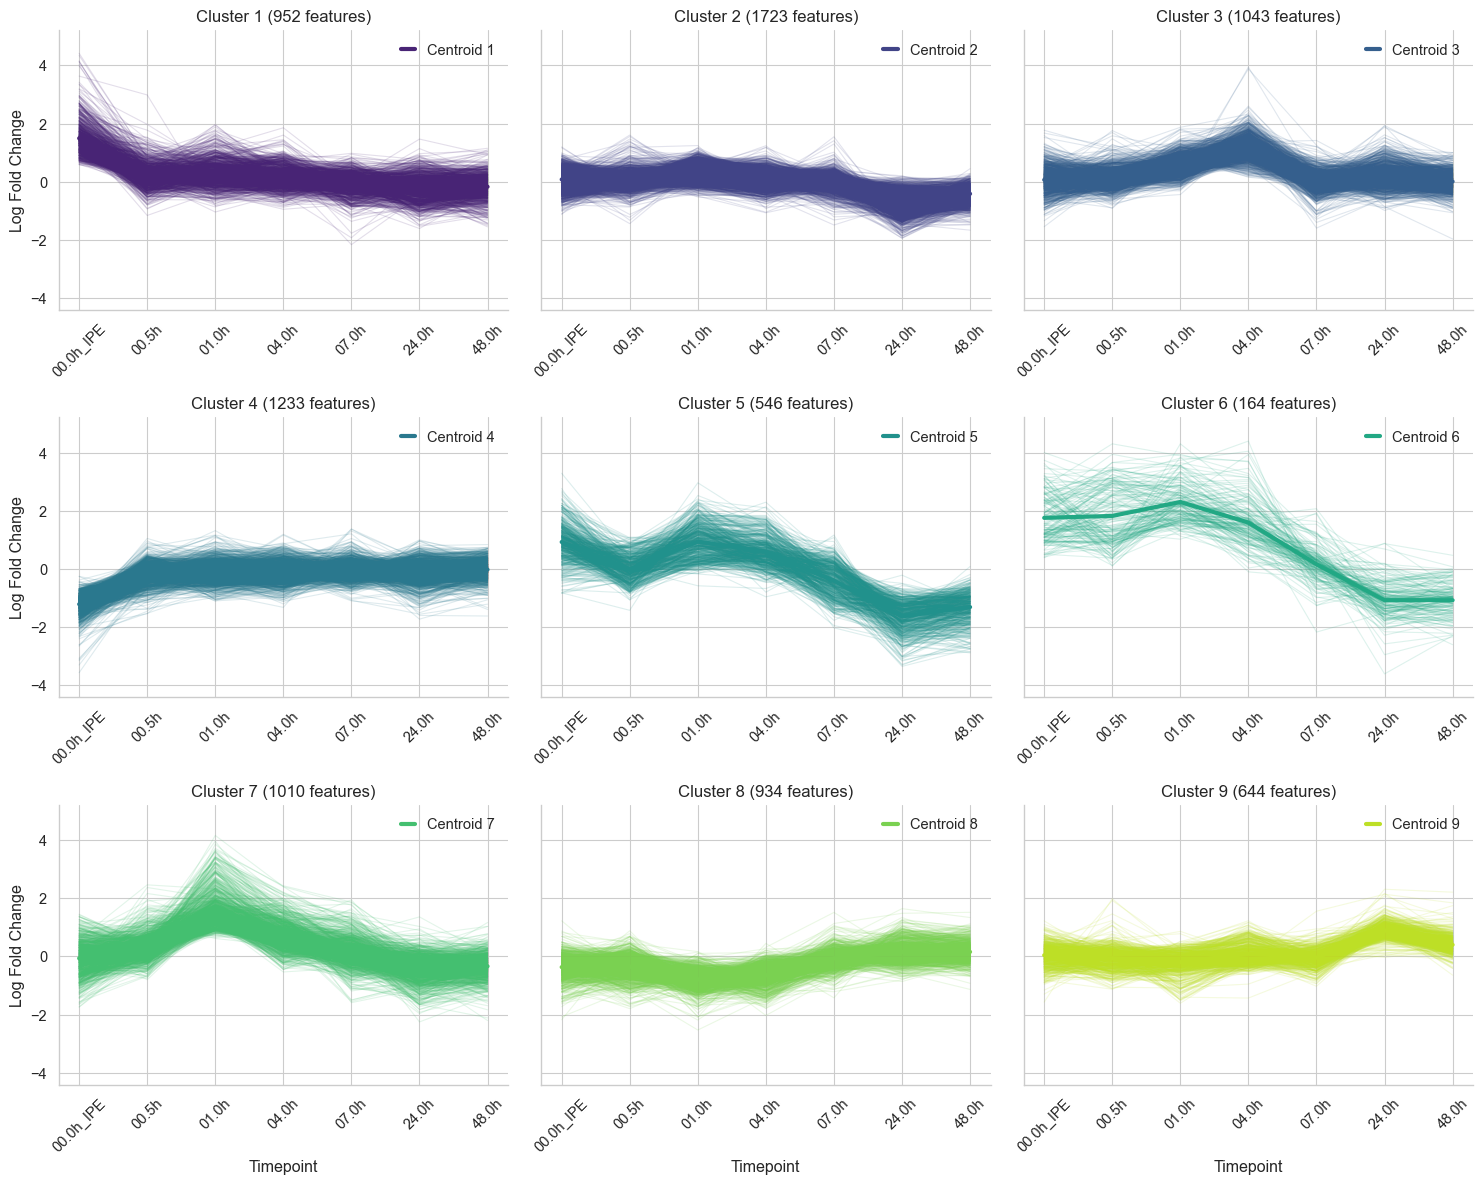

In [9]:
def plot_cluster_centroids_array(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    show_features: bool = True,
    feature_alpha: float = 0.15,
    palette: str = "viridis",
    n_cols: int = 3
):
    """
    Display one subplot per cluster (3 columns × as many rows as needed),
    mirroring the styling of `plot_individual_clusters`.

    Parameters
    ----------
    clustering_result : Dict
        Output from `cmeans_clustering`
    df : pd.DataFrame
        Original dataframe with columns `feature_ID`, `timepoint`, `logFC`, …
    show_features : bool, default=True
        Whether to overlay individual feature trajectories
    feature_alpha : float, default=0.15
        Alpha transparency for feature trajectories
    palette : str, default="viridis"
        Seaborn colour palette for clusters
    n_cols : int, default=3
        Number of columns in the subplot grid
    """
    # ── Styling ───────────────────────────────────────────────────────────────
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)

    # ── Unpack clustering result ──────────────────────────────────────────────
    centers             = clustering_result["centers"]            # (c x t)
    timepoints          = clustering_result["timepoints"]         # list-like length t
    feature_ids         = clustering_result["feature_ids"]        # length n
    cluster_assignments = clustering_result["cluster_assignments"]# length n
    n_clusters          = centers.shape[0]

    # ── Colour palette & shared y-axis limits ─────────────────────────────────
    colours   = sns.color_palette(palette, n_clusters)
    y_min, y_max = df["logFC"].min(), df["logFC"].max()
    y_range      = y_max - y_min
    y_limits     = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]

    # ── Prepare grid ──────────────────────────────────────────────────────────
    n_rows = math.ceil(n_clusters / n_cols)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 5, n_rows * 4),
        sharey=True,
        squeeze=False
    )
    axes_flat = axes.flatten()

    # Map feature_ID ➔ cluster for quick lookup
    feature_to_cluster = dict(zip(feature_ids, cluster_assignments))

    # ── Plot each cluster ─────────────────────────────────────────────────────
    for idx in range(n_clusters):
        ax = axes_flat[idx]
        cluster_colour = colours[idx]

        # Feature trajectories
        if show_features:
            for feature_id, group in df.groupby("feature_ID"):
                if feature_to_cluster.get(feature_id) == idx:
                    group_sorted = group.sort_values("timepoint")
                    ax.plot(
                        group_sorted["timepoint"],
                        group_sorted["logFC"],
                        color=cluster_colour,
                        alpha=feature_alpha,
                        linewidth=0.8
                    )

        # Centroid
        ax.plot(
            timepoints,
            centers[idx],
            color=cluster_colour,
            linewidth=3,
            label=f"Centroid {idx + 1}"
        )

        # Cluster size for title
        n_features = int(np.sum(cluster_assignments == idx))
        ax.set_title(f"Cluster {idx + 1} ({n_features} features)", fontsize=12)

        # Cosmetics
        ax.set_ylim(y_limits)
        ax.set_xticks(range(len(timepoints)))
        ax.set_xticklabels(timepoints, rotation=45)

        # Labels only on bottom row / first column
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("Timepoint")
        if idx % n_cols == 0:
            ax.set_ylabel("Log Fold Change")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(frameon=False, handlelength=1)

    # Hide unused axes
    for j in range(n_clusters, n_rows * n_cols):
        axes_flat[j].axis("off")

    plt.tight_layout()
    plt.show()


plot_cluster_centroids_array(optimal_clustering, dfmale_sig)

In [7]:
# export optimal_clustering dict to path_data/output/rat-acute-06_t68-liver_apigen-atac-seq_male_optimal_clustering.pkl
import pickle

path_out = os.path.join(path_data, 'output', 'rat-acute-06_t68-liver_apigen-atac-seq_male_optimal_clustering.pkl')

with open(path_out, 'wb') as f:
    pickle.dump(optimal_clustering, f)


In [10]:
optimal_clustering = pickle.load(open(path_out, 'rb'))
optimal_clustering.keys()

dict_keys(['centers', 'membership', 'cluster_assignments', 'classification_entropy', 'xie_beni_index', 'feature_ids', 'timepoints', 'fpc', 'random_seed'])

# Pathway Enrichment

In [5]:
import pandas as pd
import polars as pl

import skfuzzy as fuzz
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

from gprofiler import GProfiler


path_proj_root = '/Users/curtismcginity/stanford/research/proj/MoTrPAC/dev/'
path_data = os.path.join(path_proj_root, 'data')
path_data_r6m = os.path.join(path_data, 'rat-6m')
path_contrast_time_txt = os.path.join(path_data_r6m, 'rat-acute-06_t68-liver_epigen-atac-seq_da_timewise-deseq2-phase-frip-t2f_v2.0.txt')
path_indv_tsv = p=os.path.join(path_data_r6m, 'motrpac_pass1ac-06_epigen-atac-seq_t68-liver_stanford_limma_norm.tsv')

# paths to read in the pre-stored parquet files
ptxt = os.path.join(path_data_r6m, 'rat-acute-06_t68-liver_epigen-atac-seq_da_timewise-deseq2-phase-frip-t2f_v2.0.parquet')
pindv = os.path.join(path_data_r6m, 'motrpac_pass1ac-06_epigen-atac-seq_t68-liver_stanford_limma_norm.parquet')

In [ ]:
optimal_clustering.info()

AttributeError: 'dict' object has no attribute 'info'

In [6]:
import pickle

path_out = os.path.join(path_data, 'output', 'rat-acute-06_t68-liver_apigen-atac-seq_male_optimal_clustering.pkl')

optimal_clustering = pickle.load(open(path_out, 'rb'))
optimal_clustering.keys()

dict_keys(['centers', 'membership', 'cluster_assignments', 'classification_entropy', 'xie_beni_index', 'feature_ids', 'timepoints', 'fpc', 'random_seed'])

In [13]:
import pandas as pd
from gprofiler import GProfiler

# --- 1. Simulate or load your optimal_clustering dictionary ---
# Replace this with your actual data
print("Optimal clustering data (example):")
print(f"Feature IDs: {optimal_clustering['feature_ids']}")
print(f"Cluster Assignments: {optimal_clustering['cluster_assignments']}")
print("-" * 30)

# --- 2. Prepare clustered features ---
# Create a DataFrame from the feature_ids and their cluster assignments
clustered_features_df = pd.DataFrame({
    'feature_id': optimal_clustering['feature_ids'],
    'cluster_assignment': optimal_clustering['cluster_assignments']
})

# Drop duplicate (feature_id, cluster_assignment) pairs to get a unique mapping
unique_clustered_features_df = clustered_features_df.drop_duplicates().reset_index(drop=True)
print("\nUnique clustered features:")
print(unique_clustered_features_df.head())
print("-" * 30)

# --- 3. Load gene lookup data ---
gene_lookup_file_path = '/Users/curtismcginity/stanford/research/proj/MoTrPAC/dev/data/rat-6m/rat-acute-06_epigenomics_metadata_rat-acute-06_t68-liver_epigen-atac-seq_metadata_features_v1.0.txt'
gene_cols_to_use = ['feature_id', 'geneId', 'gene_name', 'short_annotation']

try:
    print(f"\nLoading gene lookup data from: {gene_lookup_file_path}")
    gene_lookup_df = pd.read_csv(gene_lookup_file_path, sep='\t', usecols=lambda col: col in gene_cols_to_use)
    
    # Ensure all required columns are present after loading
    missing_cols = [col for col in gene_cols_to_use if col not in gene_lookup_df.columns]
    if missing_cols:
        print(f"Warning: The following expected columns were not found in the gene lookup file: {missing_cols}")
        print(f"Available columns: {gene_lookup_df.columns.tolist()}")
        # Handle missing columns (e.g., by creating them with NaN or stopping execution)
        # For now, we'll proceed, but merging might fail or be incomplete.
        for col in missing_cols:
            if col not in gene_lookup_df.columns and col in ['geneId', 'gene_name', 'short_annotation']: # only add if it's a gene info col we need
                 gene_lookup_df[col] = pd.NA


    print("\nGene lookup data (first 5 rows):")
    print(gene_lookup_df.head())

except FileNotFoundError:
    print(f"Error: Gene lookup file not found at {gene_lookup_file_path}")
    gene_lookup_df = pd.DataFrame(columns=gene_cols_to_use) # Create empty df to avoid later errors
except Exception as e:
    print(f"Error loading gene lookup file: {e}")
    print("Please check the file path, delimiter (assuming tab-separated), and column names.")
    gene_lookup_df = pd.DataFrame(columns=gene_cols_to_use) # Create empty df to avoid later errors
print("-" * 30)

# --- 4. Merge clustered features with gene data ---
if not gene_lookup_df.empty and 'feature_id' in gene_lookup_df.columns:
    merged_df = pd.merge(
        unique_clustered_features_df,
        gene_lookup_df,
        on='feature_id', # Assumes the column name is 'feature_id' in both DataFrames
        how='left'
    )
    print("\nMerged data (first 5 rows):")
    print(merged_df.head())
else:
    print("\nSkipping merge due to issues with gene lookup data.")
    # Create a basic merged_df structure if gene_lookup_df is empty or missing 'feature_id'
    # to allow pathway enrichment step to run (it will likely find no genes).
    merged_df = unique_clustered_features_df.copy()
    for col in ['geneId', 'gene_name', 'short_annotation']:
        if col not in merged_df.columns:
             merged_df[col] = pd.NA
print("-" * 30)

# --- 5. Perform pathway enrichment for each cluster ---
# Ensure 'geneId' column exists, even if it's all NA, to prevent KeyErrors
if 'geneId' not in merged_df.columns:
    merged_df['geneId'] = pd.NA

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Store enrichment results for each cluster
enrichment_results_by_cluster = {}

# Iterate over each cluster
for cluster_id in sorted(merged_df['cluster_assignment'].unique()):
    print(f"\nPerforming pathway enrichment for Cluster {cluster_id}...")
    
    # Get genes for the current cluster
    # Using 'geneId'. If 'geneId' is not available or mostly NaN, you might prefer 'gene_name'.
    # Ensure gene list contains only non-null, string-type gene identifiers.
    genes_in_cluster = merged_df[merged_df['cluster_assignment'] == cluster_id]['geneId'].dropna().astype(str).tolist()
    
    if not genes_in_cluster:
        print(f"No genes found for Cluster {cluster_id}. Skipping enrichment.")
        enrichment_results_by_cluster[cluster_id] = pd.DataFrame() # Empty DataFrame for no results
        continue
        
    print(f"Number of genes in Cluster {cluster_id}: {len(genes_in_cluster)}")
    # print(f"First 5 genes: {genes_in_cluster[:5]}") # Uncomment to see sample genes

    try:
        # Perform enrichment analysis
        # You might need to adjust the organism based on your data (e.g., 'hsapiens' for human, 'mmusculus' for mouse)
        # For Rat, it's typically 'rnorvegicus'
        enrichment_df = gp.profile(
            organism='rnorvegicus', # Rat
            query=genes_in_cluster,
            sources=['GO:BP', 'KEGG', 'REAC'], # Example sources: GO Biological Process, KEGG, Reactome
            user_threshold=0.05, # P-value threshold
            significance_threshold_method='gSCS' # Correction method
        )
        
        if not enrichment_df.empty:
            print(f"Enrichment analysis successful for Cluster {cluster_id}.")
            # You might want to sort or filter results, e.g., by p-value
            enrichment_results_by_cluster[cluster_id] = enrichment_df.sort_values(by='p_value').reset_index(drop=True)
            print(f"Found {len(enrichment_df)} significant pathways for Cluster {cluster_id}.")
            print(enrichment_results_by_cluster[cluster_id][['native', 'name', 'p_value', 'source']].head())
        else:
            print(f"No significant pathways found for Cluster {cluster_id}.")
            enrichment_results_by_cluster[cluster_id] = pd.DataFrame()

    except Exception as e:
        print(f"Error during enrichment analysis for Cluster {cluster_id}: {e}")
        enrichment_results_by_cluster[cluster_id] = pd.DataFrame() # Store empty df on error

print("\n--- Pathway Enrichment Workflow Complete ---")

# Example: Accessing results for a specific cluster
# if 0 in enrichment_results_by_cluster and not enrichment_results_by_cluster[0].empty:
#     print("\nEnrichment results for Cluster 0 (Top 5):")
#     print(enrichment_results_by_cluster[0][['native', 'name', 'p_value', 'source', 'intersection_size']].head())
# else:
#     print("\nNo enrichment results to show for Cluster 0 or an error occurred.")


Optimal clustering data (example):
Feature IDs: ['chr10:100421394-100422338', 'chr10:100516193-100517343', 'chr10:100519878-100520078', 'chr10:100522093-100523569', 'chr10:100526510-100527380', 'chr10:100529526-100530683', 'chr10:100533209-100534463', 'chr10:101246685-101247667', 'chr10:101254948-101256229', 'chr10:101363443-101363769', 'chr10:101661900-101662406', 'chr10:102279024-102279269', 'chr10:102413035-102413919', 'chr10:102461009-102461483', 'chr10:102463220-102463771', 'chr10:102476767-102479028', 'chr10:102491417-102491688', 'chr10:102506983-102509056', 'chr10:102527563-102528400', 'chr10:102562012-102562943', 'chr10:103192992-103193416', 'chr10:103193495-103193709', 'chr10:103402936-103404185', 'chr10:103442677-103443405', 'chr10:10379849-10381535', 'chr10:104531549-104532026', 'chr10:104612628-104614322', 'chr10:104955419-104956654', 'chr10:105222150-105223742', 'chr10:105225196-105225654', 'chr10:105351864-105352721', 'chr10:105428708-105429422', 'chr10:105596117-10559783

In [10]:
enrichment_results_by_cluster[5].head()

source      native                                       name       p_value  \
0  GO:BP  GO:0032501           multicellular organismal process  1.096270e-13   
1  GO:BP  GO:0048856           anatomical structure development  3.213935e-12   
2  GO:BP  GO:0032502                      developmental process  1.521466e-11   
3  GO:BP  GO:0048518  positive regulation of biological process  1.825028e-11   
4  GO:BP  GO:0048731                         system development  2.658463e-11   

   significant                                        description  term_size  \
0         True  "Any biological process, occurring at the leve...       4529   
1         True  "The biological process whose specific outcome...       3953   
2         True  "A biological process whose specific outcome i...       4229   
3         True  "Any process that activates or increases the f...       4139   
4         True  "The process whose specific outcome is the pro...       2612   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0         311                141                  19132   0.453376  0.031133   
1         311                126                  19132   0.405145  0.031875   
2         311                130                  19132   0.418006  0.030740   
3         311                128                  19132   0.411576  0.030925   
4         311                 95                  19132   0.305466  0.036371   

     query                   parents  
0  query_1              [GO:0008150]  
1  query_1              [GO:0032502]  
2  query_1              [GO:0008150]  
3  query_1  [GO:0008150, GO:0050789]  
4  query_1  [GO:0007275, GO:0048856]

--- Starting Post-Processing of Enrichment Results ---

Processing Cluster 0...
Cluster 0: Filtered by term_size (0 < size < 400). Kept 35 out of 133 pathways.
Cluster 0: Selected top 35 pathways by p-value (max 75).

Processing Cluster 1...
Cluster 1: Filtered by term_size (0 < size < 400). Kept 62 out of 220 pathways.
Cluster 1: Selected top 62 pathways by p-value (max 75).

Processing Cluster 2...
Cluster 2: Filtered by term_size (0 < size < 400). Kept 21 out of 159 pathways.
Cluster 2: Selected top 21 pathways by p-value (max 75).

Processing Cluster 3...
Cluster 3: Filtered by term_size (0 < size < 400). Kept 21 out of 131 pathways.
Cluster 3: Selected top 21 pathways by p-value (max 75).

Processing Cluster 4...
Cluster 4: Filtered by term_size (0 < size < 400). Kept 29 out of 42 pathways.
Cluster 4: Selected top 29 pathways by p-value (max 75).

Processing Cluster 5...
Cluster 5: Filtered by term_size (0 < size < 400). Kept 8 out of 10 pathways.
Cluster 5: Selected top 8 pathway

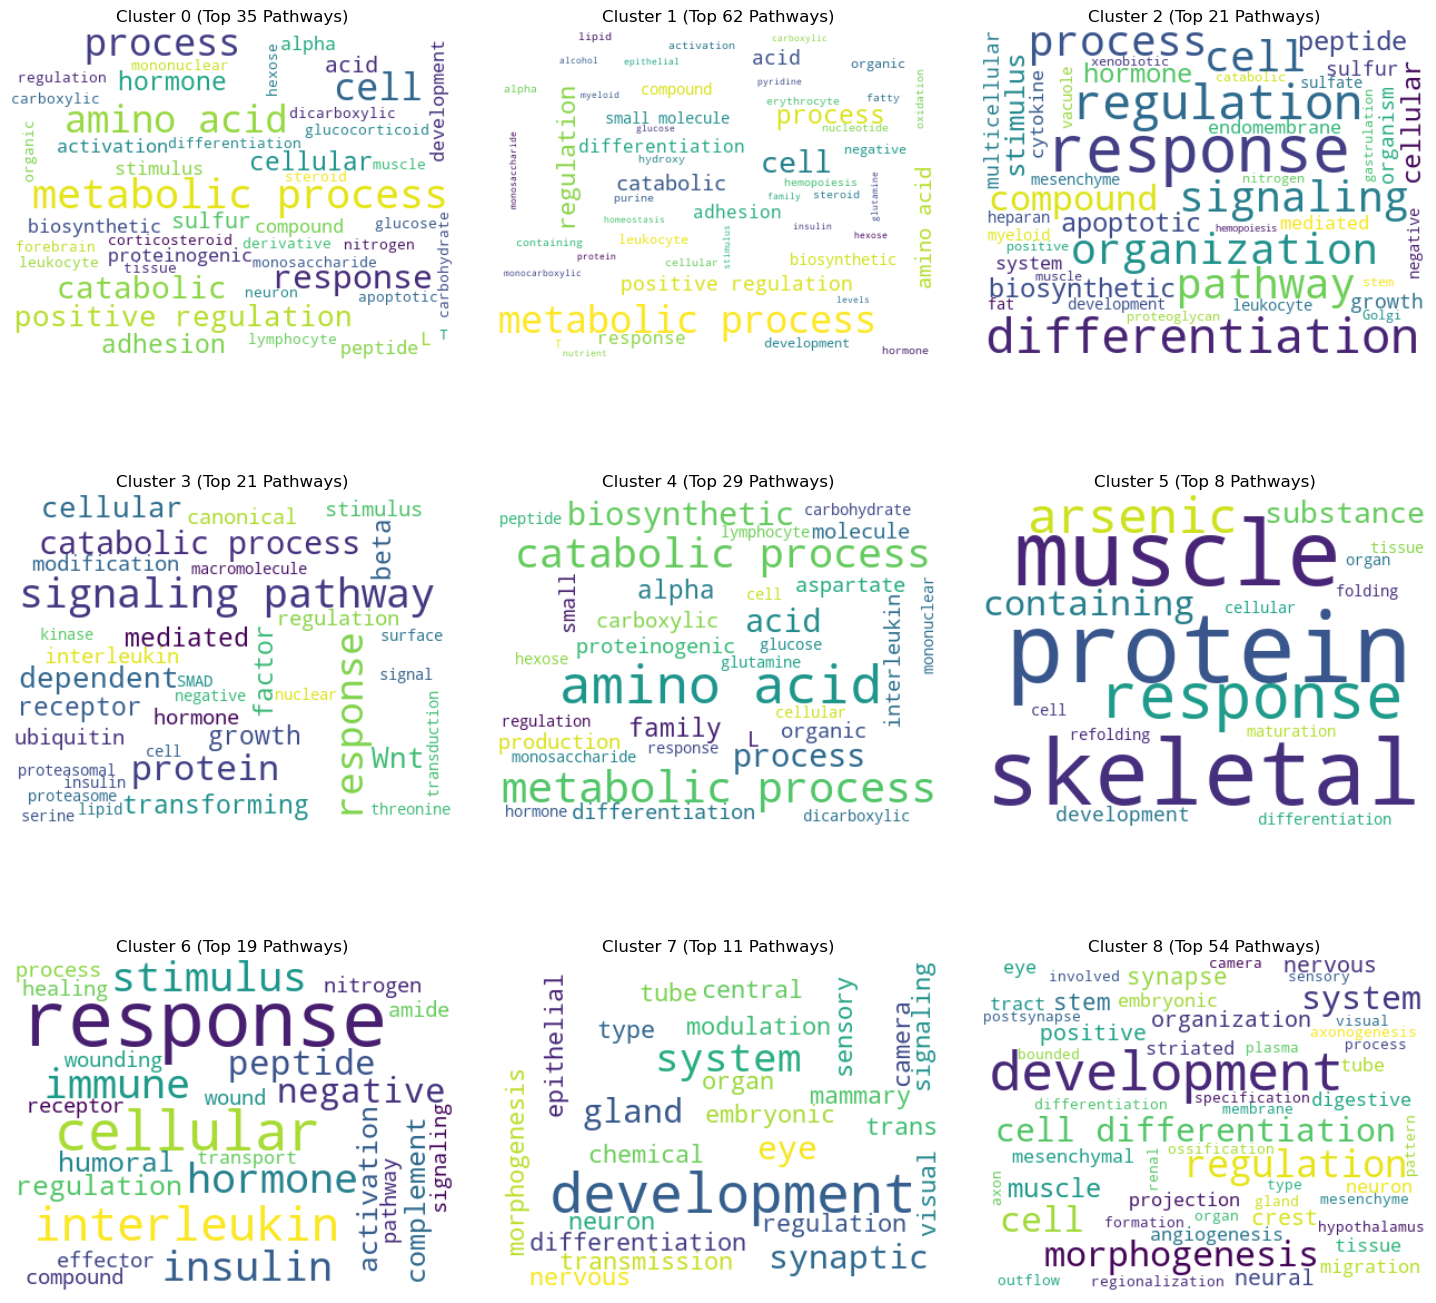


--- Word Cloud Visualization Attempted ---


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

# --- Assume enrichment_results_by_cluster is available from the previous block ---
# For testing, let's create a sample structure for enrichment_results_by_cluster
# Replace this with your actual data if running this block standalone.
if 'enrichment_results_by_cluster' not in globals():
    print("enrichment_results_by_cluster not found. Creating sample data for demonstration.")
    enrichment_results_by_cluster = {
        0: pd.DataFrame({
            'native': [f'GO:{i:07d}' for i in range(30)],
            'name': [f'Pathway Alpha {i}' for i in range(30)],
            'p_value': [0.001 * (i + 1) for i in range(30)],
            'term_size': [5 + i*2 for i in range(30)], # Varied term sizes
            'source': ['GO:BP'] * 30
        }),
        1: pd.DataFrame({
            'native': [f'KEGG:{i:05d}' for i in range(25)],
            'name': [f'Pathway Beta {i}' for i in range(25)],
            'p_value': [0.002 * (i + 1) for i in range(25)],
            'term_size': [8, 12, 15, 20, 30, 50, 70, 90, 110, 130, 150, 10, 5, 200, 260, 300, 100, 120, 140, 160, 180, 190, 210, 230, 240], # some outside range
            'source': ['KEGG'] * 25
        }),
        2: pd.DataFrame({ # This cluster will have few terms after filtering
            'native': [f'REAC:{i}' for i in range(5)],
            'name': [f'Pathway Gamma {i}' for i in range(5)],
            'p_value': [0.01 * (i + 1) for i in range(5)],
            'term_size': [5, 8, 12, 15, 20], # Small term sizes, 12, 15, 20 will pass
            'source': ['REAC'] * 5
        }),
        3: pd.DataFrame() # Empty dataframe for one cluster
    }
    # Add a cluster that might become empty after term_size filtering
    enrichment_results_by_cluster[4] = pd.DataFrame({
            'native': [f'GO:{i:07d}' for i in range(5)],
            'name': [f'Pathway Delta {i}' for i in range(5)],
            'p_value': [0.001 * (i + 1) for i in range(5)],
            'term_size': [5, 6, 7, 8, 9], # All will be filtered out
            'source': ['GO:BP'] * 5
        })
    enrichment_results_by_cluster[5] = pd.DataFrame({
            'native': [f'GO:{i:07d}' for i in range(5)],
            'name': [f'Pathway Epsilon {i}' for i in range(5)],
            'p_value': [0.001 * (i + 1) for i in range(5)],
            'term_size': [300, 310, 320, 330, 340], # All will be filtered out
            'source': ['GO:BP'] * 5
        })


# --- 1. Post-processing: Filter enrichment results ---
term_size_min = 0
term_size_max = 400
top_n_pathways = 75

processed_enrichment_results_by_cluster = {}

print("--- Starting Post-Processing of Enrichment Results ---")
for cluster_id, enrichment_df in enrichment_results_by_cluster.items():
    print(f"\nProcessing Cluster {cluster_id}...")
    if enrichment_df.empty:
        print(f"Cluster {cluster_id}: No enrichment results to process.")
        processed_enrichment_results_by_cluster[cluster_id] = pd.DataFrame()
        continue

    # Ensure 'term_size' and 'p_value' columns exist
    if 'term_size' not in enrichment_df.columns:
        print(f"Cluster {cluster_id}: Warning - 'term_size' column not found. Skipping term size filtering.")
        filtered_df = enrichment_df.copy()
    else:
        # Apply term_size filter
        initial_pathway_count = len(enrichment_df)
        filtered_df = enrichment_df[
            (enrichment_df['term_size'] > term_size_min) & 
            (enrichment_df['term_size'] < term_size_max)
        ].copy() # Use .copy() to avoid SettingWithCopyWarning
        
        print(f"Cluster {cluster_id}: Filtered by term_size ({term_size_min} < size < {term_size_max}). Kept {len(filtered_df)} out of {initial_pathway_count} pathways.")

        if filtered_df.empty and initial_pathway_count > 0:
            print(f"Cluster {cluster_id}: ERROR - Term size filtering removed all pathways.")
            # We will store the empty dataframe and it won't be plotted.
            
    if filtered_df.empty:
        processed_enrichment_results_by_cluster[cluster_id] = pd.DataFrame()
        continue
        
    # Ensure 'p_value' column exists for sorting
    if 'p_value' not in filtered_df.columns:
        print(f"Cluster {cluster_id}: Warning - 'p_value' column not found. Cannot sort by p-value or select top N.")
        processed_enrichment_results_by_cluster[cluster_id] = filtered_df # Store as is
        continue

    # Filter to top N (e.g., 20) by p_value
    # Sort by p_value first (ascending)
    sorted_df = filtered_df.sort_values(by='p_value', ascending=True)
    top_n_df = sorted_df.head(top_n_pathways)
    print(f"Cluster {cluster_id}: Selected top {len(top_n_df)} pathways by p-value (max {top_n_pathways}).")
    
    processed_enrichment_results_by_cluster[cluster_id] = top_n_df

print("\n--- Post-Processing Complete ---")

# --- 2. Visualization: Word Clouds ---
print("\n--- Starting Word Cloud Visualization ---")

# Collect clusters that have data for plotting
clusters_to_plot = {
    cid: df for cid, df in processed_enrichment_results_by_cluster.items() 
    if not df.empty and 'name' in df.columns and not df['name'].dropna().empty
}

if not clusters_to_plot:
    print("No data available for word cloud visualization after processing.")
else:
    num_clusters_with_data = len(clusters_to_plot)
    cols = 3
    rows = math.ceil(num_clusters_with_data / cols)
    
    fig_height_per_row = 5 
    fig_width = cols * 5

    if rows == 0 : # if no cluster has data
        print("No clusters with valid pathway names to generate word clouds.")
    else:
        plt.figure(figsize=(fig_width, rows * fig_height_per_row))

        plot_idx = 1
        for cluster_id, result_df in clusters_to_plot.items():
            pathway_names = result_df['name'].dropna().tolist()
            
            if not pathway_names:
                print(f"Cluster {cluster_id}: No pathway names available for word cloud.")
                # Optionally, create an empty subplot or skip
                ax = plt.subplot(rows, cols, plot_idx)
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, color='grey')
                ax.set_title(f"Cluster {cluster_id}\n(No pathway names)")
                ax.axis('off')
                plot_idx += 1
                continue

            text = " ".join(pathway_names)
            
            try:
                wordcloud = WordCloud(
                    width=400, 
                    height=300, 
                    background_color='white',
                    colormap='viridis', # You can choose other colormaps
                    max_words=50, # Limit the number of words in the cloud
                    contour_width=1,
                    contour_color='steelblue'
                ).generate(text)
                
                ax = plt.subplot(rows, cols, plot_idx)
                ax.imshow(wordcloud, interpolation='bilinear')
                ax.set_title(f"Cluster {cluster_id} (Top {len(pathway_names)} Pathways)")
                ax.axis('off')
                plot_idx += 1
            except Exception as e:
                print(f"Cluster {cluster_id}: Error generating word cloud - {e}")
                ax = plt.subplot(rows, cols, plot_idx)
                ax.text(0.5, 0.5, 'Error', ha='center', va='center', fontsize=12, color='red')
                ax.set_title(f"Cluster {cluster_id}\n(Word cloud error)")
                ax.axis('off')
                plot_idx +=1


        # Hide any unused subplots if the number of clusters is not a multiple of 'cols'
        while plot_idx <= rows * cols:
            ax = plt.subplot(rows, cols, plot_idx)
            ax.axis('off') # Turn off axis for unused subplots
            plot_idx += 1
            
        plt.tight_layout(pad=3.0)
        plt.show()

print("\n--- Word Cloud Visualization Attempted ---")

Using dfmale_sig from global scope.

--- Preparing Data for Combined Plot ---


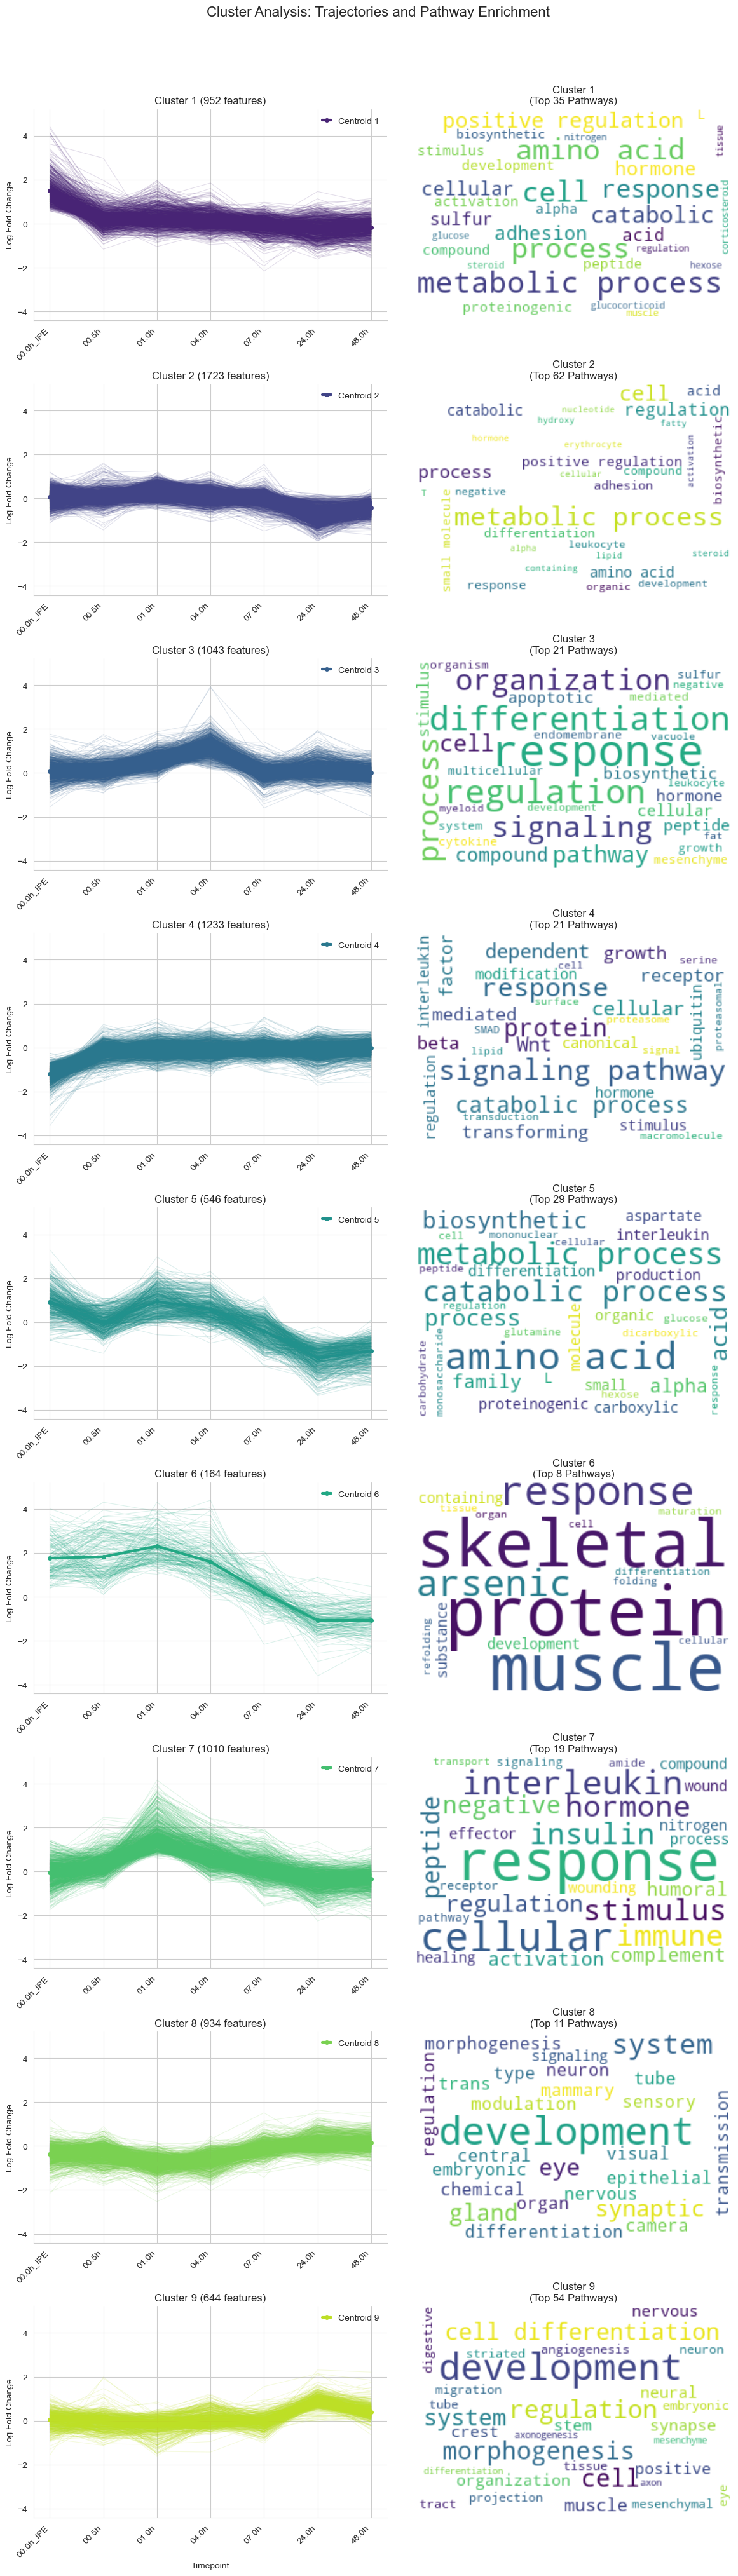


--- Combined Plot Generation Attempted ---


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For color palettes
from wordcloud import WordCloud
import math

# --- 0. Ensure dfmale_sig is in global scope ---
# For demonstration, creating a sample dfmale_sig in LONG format.
# REPLACE THIS WITH YOUR ACTUAL dfmale_sig DATAFRAME.
if 'dfmale_sig' not in globals():
    print("dfmale_sig not found in global scope. Creating sample dfmale_sig (long format).")
    _num_sample_features = 15
    _sample_fids_long = []
    _sample_tps_long = []
    _sample_logfc_long = []
    _timepoints_labels = ['T1', 'T2', 'T3', 'T4']
    for i in range(_num_sample_features):
        for tp_label in _timepoints_labels:
            _sample_fids_long.append(f'feat{i}')
            _sample_tps_long.append(tp_label)
            _sample_logfc_long.append(np.random.randn() * 0.5 + (i % 3 - 1)) # Some variation

    dfmale_sig = pd.DataFrame({
        'feature_ID': _sample_fids_long,
        'timepoint': _sample_tps_long,
        'logFC': _sample_logfc_long
    })
    print("Sample dfmale_sig (long format) created:")
    print(dfmale_sig.head())
else:
    print("Using dfmale_sig from global scope.")
    # Basic check for required columns if dfmale_sig is from global
    if not all(col in dfmale_sig.columns for col in ['feature_ID', 'timepoint', 'logFC']):
        print("WARNING: dfmale_sig from global scope is missing one or more required columns: 'feature_ID', 'timepoint', 'logFC'")


# --- 1. Sample Data (REPLACE with your actual data for optimal_clustering and processed_enrichment) ---
if 'optimal_clustering' not in globals() or 'processed_enrichment_results_by_cluster' not in globals():
    print("optimal_clustering or processed_enrichment_results_by_cluster not found. Creating sample data.")
    
    _timepoints_labels_clustering = ['T1', 'T2', 'T3', 'T4'] # Must match timepoints in dfmale_sig
    _num_clusters_sample = 3
    
    optimal_clustering = {
        'centers': np.random.randn(_num_clusters_sample, len(_timepoints_labels_clustering)),
        'timepoints': _timepoints_labels_clustering,
        'feature_ids': dfmale_sig['feature_ID'].unique().tolist() if 'dfmale_sig' in globals() else [f'feat{i}' for i in range(15)], # Feature IDs that were clustered
        'cluster_assignments': np.random.randint(0, _num_clusters_sample, len(dfmale_sig['feature_ID'].unique()) if 'dfmale_sig' in globals() else 15),
    }
    # Ensure cluster_assignments length matches feature_ids length
    if len(optimal_clustering['feature_ids']) != len(optimal_clustering['cluster_assignments']):
         optimal_clustering['cluster_assignments'] = np.random.randint(0, _num_clusters_sample, len(optimal_clustering['feature_ids']))


    processed_enrichment_results_by_cluster = {
        i: pd.DataFrame({
            'name': [f'Pathway Cluster {i}-{j}' for j in range(np.random.randint(3,7))],
            'p_value': np.random.rand(np.random.randint(3,7)) * 0.01,
            'term_size': np.random.randint(15, 200, np.random.randint(3,7))
        }) for i in range(_num_clusters_sample)
    }
    # Add an empty one for testing
    if _num_clusters_sample > 0:
        processed_enrichment_results_by_cluster[_num_clusters_sample-1] = pd.DataFrame()


# --- End Sample Data ---

# --- 2. Prepare data and common plot elements ---
print("\n--- Preparing Data for Combined Plot ---")

# Unpack optimal_clustering results
oc_centers = optimal_clustering.get('centers')
oc_timepoints = optimal_clustering.get('timepoints')
oc_feature_ids = optimal_clustering.get('feature_ids')
oc_cluster_assignments = optimal_clustering.get('cluster_assignments')
n_clusters = 0
if isinstance(oc_centers, np.ndarray):
    n_clusters = oc_centers.shape[0]

# Check essential data
if oc_centers is None or oc_timepoints is None or oc_feature_ids is None or oc_cluster_assignments is None or n_clusters == 0:
    print("ERROR: optimal_clustering dictionary is missing essential keys ('centers', 'timepoints', 'feature_ids', 'cluster_assignments') or has no clusters.")
    # Consider exiting or raising an error if this script part can't proceed
    all_cluster_ids = sorted(list(processed_enrichment_results_by_cluster.keys())) # Fallback for wordclouds if centroids fail
else:
    # Map feature_ID to cluster for quick lookup
    feature_to_cluster = dict(zip(oc_feature_ids, oc_cluster_assignments))
    all_cluster_ids = list(range(n_clusters)) # Assume 0-indexed clusters from centers

# Global Y-axis limits for trajectory plots from dfmale_sig['logFC']
y_min_global, y_max_global = -1, 1 # Default
if 'logFC' in dfmale_sig.columns:
    y_min_global = dfmale_sig["logFC"].min()
    y_max_global = dfmale_sig["logFC"].max()
    y_range_global = y_max_global - y_min_global
    y_limits_global = [y_min_global - 0.1 * y_range_global, y_max_global + 0.1 * y_range_global]
else:
    print("Warning: 'logFC' column not found in dfmale_sig. Using default y-limits for trajectory plots.")
    y_limits_global = [-1, 1]


# Color palette
cluster_palette = sns.color_palette("viridis", n_clusters if n_clusters > 0 else 1)


# --- 3. Plotting ---
if not all_cluster_ids and not processed_enrichment_results_by_cluster:
    print("No cluster data or enrichment data available to plot.")
else:
    # If only enrichment results are present, ensure all_cluster_ids covers them
    if not all_cluster_ids and processed_enrichment_results_by_cluster:
        all_cluster_ids = sorted(list(processed_enrichment_results_by_cluster.keys()))
        print(f"Plotting based on enrichment cluster IDs: {all_cluster_ids}")
        n_clusters = len(all_cluster_ids) # Update n_clusters if it was 0

    num_rows_plot = max(1, n_clusters) # Ensure at least one row if there are clusters
    cols_plot = 2
    
    fig_height_per_row = 4.5
    fig_width = 12

    plt.figure(figsize=(fig_width, num_rows_plot * fig_height_per_row))
    sns.set_style("whitegrid") # Style similar to plot_cluster_centroids_array

    plot_idx_offset = 0 # To handle cases where cluster_id might not start at 0 or be sequential

    for i, cluster_id in enumerate(all_cluster_ids):
        display_cluster_num = cluster_id + 1 # For 1-indexed titles

        # --- Left Column: Cluster Features and Centroid Plot ---
        ax_left = plt.subplot(num_rows_plot, cols_plot, i * cols_plot + 1)
        
        left_plot_generated = False
        n_features_in_current_cluster = 0

        # Check if this cluster_id is valid for centroid plotting
        if oc_centers is not None and cluster_id < n_clusters:
            current_cluster_color = cluster_palette[cluster_id % len(cluster_palette)]

            # Plot individual features
            # This assumes dfmale_sig has 'feature_ID', 'timepoint', 'logFC'
            if 'feature_ID' in dfmale_sig.columns and 'timepoint' in dfmale_sig.columns and 'logFC' in dfmale_sig.columns:
                # Collect features for this cluster
                features_this_cluster = [fid for fid, cl_assign in feature_to_cluster.items() if cl_assign == cluster_id]
                n_features_in_current_cluster = len(features_this_cluster)

                for feature_id_val in features_this_cluster:
                    feature_data = dfmale_sig[dfmale_sig['feature_ID'] == feature_id_val].sort_values('timepoint')
                    if not feature_data.empty:
                        # Ensure the 'timepoint' values are plottable and correspond to oc_timepoints order
                        # Matplotlib can plot strings on x-axis if they are consistent
                        ax_left.plot(
                            feature_data['timepoint'], # Should match labels in oc_timepoints
                            feature_data['logFC'],
                            color=current_cluster_color,
                            alpha=0.15, # feature_alpha from original function
                            linewidth=0.8
                        )
                left_plot_generated = True # At least attempted to plot features
            else:
                print(f"Cluster {cluster_id}: dfmale_sig missing required columns for feature plotting.")

            # Plot centroid
            ax_left.plot(
                oc_timepoints, # X-axis for centroid
                oc_centers[cluster_id], # Y-axis for centroid
                color=current_cluster_color,
                linewidth=3,
                marker='o', markersize=4, # Added marker for visibility
                label=f"Centroid {display_cluster_num}"
            )
            ax_left.legend(frameon=False, handlelength=1, loc='upper right')
            left_plot_generated = True # Centroid was plotted
            
            # Styling from plot_cluster_centroids_array
            ax_left.set_title(f"Cluster {display_cluster_num} ({n_features_in_current_cluster} features)", fontsize=12)
            ax_left.set_ylim(y_limits_global)
            ax_left.set_xticks(range(len(oc_timepoints))) # Numerical positions for ticks
            ax_left.set_xticklabels(oc_timepoints, rotation=45, ha="right")

            if i == num_rows_plot - 1 : # Bottom row
                ax_left.set_xlabel("Timepoint")
            if 0 == 0: # First column (always true as it's the only left plot in this row)
                ax_left.set_ylabel("Log Fold Change")
            
            ax_left.spines["top"].set_visible(False)
            ax_left.spines["right"].set_visible(False)

        else: # No valid centroid data for this cluster_id
            ax_left.text(0.5, 0.5, 'No Centroid Data Available', ha='center', va='center', fontsize=10, color='grey')
            ax_left.set_title(f"Cluster {display_cluster_num}\n(No Centroid Data)")
            ax_left.set_xticks([])
            ax_left.set_yticks([])
            left_plot_generated = False


        # --- Right Column: Word Cloud ---
        ax_right = plt.subplot(num_rows_plot, cols_plot, i * cols_plot + 2)
        wordcloud_generated = False
        pathway_names_for_title = []
        
        if cluster_id in processed_enrichment_results_by_cluster:
            result_df = processed_enrichment_results_by_cluster[cluster_id]
            if not result_df.empty and 'name' in result_df.columns:
                pathway_names_for_title = result_df['name'].dropna().tolist()
                if pathway_names_for_title:
                    text = " ".join(pathway_names_for_title)
                    try:
                        wordcloud = WordCloud(
                            width=300, height=200, background_color='white',
                            colormap='viridis', max_words=30,
                            contour_width=1, contour_color='steelblue'
                        ).generate(text)
                        ax_right.imshow(wordcloud, interpolation='bilinear')
                        wordcloud_generated = True
                    except Exception as e:
                        print(f"Cluster {cluster_id}: Error generating word cloud - {e}")
                        ax_right.text(0.5, 0.5, 'Word Cloud Error', ha='center', va='center', fontsize=10, color='red')
                else: 
                     ax_right.text(0.5, 0.5, 'No Pathway Names', ha='center', va='center', fontsize=10, color='grey')
            else: 
                ax_right.text(0.5, 0.5, 'No Enrichment Data', ha='center', va='center', fontsize=10, color='grey')
        else: 
            ax_right.text(0.5, 0.5, 'No Processed Enrichment Results for Cluster', ha='center', va='center', fontsize=10, color='grey')

        if wordcloud_generated:
            right_title_info = f"(Top {len(pathway_names_for_title)} Pathways)"
            ax_right.set_title(f"Cluster {display_cluster_num}\n{right_title_info}")
        else:
             ax_right.set_title(f"Cluster {display_cluster_num}\n(No Word Cloud Data)")
        ax_right.axis('off')

    plt.suptitle("Cluster Analysis: Trajectories and Pathway Enrichment", fontsize=16, y=1.00) # Adjust y for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
    plt.show()
    print("\n--- Combined Plot Generation Attempted ---")


In [40]:
dfmale_sig.head()

NameError: name 'dfmale_sig' is not defined

In [8]:
import pickle

# read in liver male best seeds and extract them to a list
path_to_best_seeds = "/Users/curtismcginity/stanford/research/proj/MoTrPAC/dev/data/output/liver/liver_male_best_seeds.pkl"

# read in pickle file
with open(path_to_best_seeds, 'rb') as f:
    best_seeds_dict = pickle.load(f)

# Extract seeds into a list
best_seeds_list = list(best_seeds_dict.values())
print("Best seeds:", best_seeds_list)



Best seeds: [57386, 15184, 82196, 23642, 57386, 6259, 15184, 9620, 88540, 57914, 55293, 96857, 7553]


In [11]:
print(best_seeds_dict)

{3: 57386, 4: 15184, 5: 82196, 6: 23642, 7: 57386, 8: 6259, 9: 15184, 10: 9620, 11: 88540, 12: 57914, 13: 55293, 14: 96857, 15: 7553}
